#### Topic Modelling
##### Extracting Hidden Topics from Journal Article 'keywords'
Steps
+ Preprocessing the data using NLP techniques
+ Applying different topic modelling methods such as LDA, NMF, CorEx, and Top2Vec.

In [6]:
# Import Dependencies

import pandas as pd
import numpy as np

import pickle
import regex as re

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn.decomposition import NMF
from corextopic import corextopic as ct
from top2vec import Top2Vec

import pyLDAvis
import pyLDAvis.gensim

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from pprint import pprint

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)  

In [7]:
# Read Pickle file for Article Keywords

with open('data/keywords', 'rb') as f:
    JourKey = pickle.load(f)            # Article Keywords

with open('data/title', 'rb') as f:
    JourTit = pickle.load(f)            # Article Title 

In [8]:
# Create a dataframe

df_Key = pd.DataFrame(JourTit, columns=['Title'])       # Title is just kept corresponding to its keywords and is not used for Topic modeling here

df_Key['Keywords'] = pd.DataFrame(JourKey, columns=['Keywords'])

In [9]:
# Check the details of the dataframe
#df_Key.head(2)
print('Shape    -', df_Key.shape)
print('Info     -', df_Key.info())

Shape    - (3395, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     3395 non-null   object
 1   Keywords  3395 non-null   object
dtypes: object(2)
memory usage: 53.2+ KB
Info     - None


In [10]:
# Remove symbols

df_Key['Keywords_Cleaned'] = df_Key.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['Keywords']).lower()),axis=1)

In [11]:
# Tokenization  : breaking the raw text into small chunks

df_Key['Keywords_Cleaned'] = df_Key.apply(lambda row: (word_tokenize(row['Keywords_Cleaned'])), axis = 1)

#df_Key.head(10)

In [12]:
# Removing Stopwords

stop_words = (stopwords.words('english'))
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])      # Remove others words that are not useful

df_Key['Keywords_Cleaned'] = df_Key.apply(lambda row: ([w for w in row['Keywords_Cleaned'] if w not in stop_words]),axis=1)


In [13]:
# Lemmatization

lmtzr = WordNetLemmatizer()
df_Key['Keywords_Cleaned'] = df_Key.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['Keywords_Cleaned']]), axis=1)

In [14]:
# Checking
#df_Key.head(5)
print(len(df_Key['Keywords_Cleaned']))

3395


#### For Natural Language Processing several methods are tested to extract the Topics
+ LDA (Latent Dirichlet Allocation)
+ NMF (Non Negative Matrix Factorization)
+ CorEx (Correlation Explanation)
+ Top2Vec

#### - LDA (Latent Dirichlet Allocation)

In [15]:
# Creating Dictionary and Corpus

dictionary = corpora.Dictionary(df_Key['Keywords_Cleaned'])                 # Gensim corpora dictionary.
texts = df_Key['Keywords_Cleaned']                                          # Dataframe
corpus = [dictionary.doc2bow(text) for text in df_Key['Keywords_Cleaned']]  # Convert Document in to a Bag of Words

In [16]:
# Building LDA Model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=6,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Gensim:  designed to extract semantic topics from documents.
# Topic: A repeating group of words frequently occurring together.

In [17]:
# Printing the Keywords in topics

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.036*"behavior" + 0.033*"sustainable" + 0.026*"technology" + '
  '0.023*"modeling" + 0.020*"environmental" + 0.018*"network" + 0.017*"based" '
  '+ 0.012*"consumer" + 0.011*"response" + 0.011*"demand"'),
 (1,
  '0.031*"biomass" + 0.031*"electrolyte" + 0.023*"fuel" + 0.020*"cell" + '
  '0.020*"microbial" + 0.017*"electrode" + 0.015*"material" + '
  '0.014*"conversion" + 0.013*"biofuel" + 0.013*"microalgae"'),
 (2,
  '0.107*"energy" + 0.054*"lithium" + 0.037*"ion" + 0.029*"thermal" + '
  '0.029*"storage" + 0.021*"rate" + 0.017*"sustainability" + '
  '0.016*"electrochemical" + 0.015*"renewable" + 0.012*"reactor"'),
 (3,
  '0.070*"carbon" + 0.067*"solid" + 0.037*"utilization" + 0.030*"heat" + '
  '0.029*"state" + 0.023*"capture" + 0.020*"surface" + 0.014*"organic" + '
  '0.014*"method" + 0.013*"sulfide"'),
 (4,
  '0.072*"system" + 0.038*"power" + 0.032*"efficiency" + 0.032*"gas" + '
  '0.029*"oxide" + 0.022*"stability" + 0.016*"natural" + 0.015*"assessment" + '
  '0.014*"decision"

Coherence scores are checked by decreasing/increasing the number of topics

In [18]:
# Evaluate the LDA model results

# a) Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus))   # a measure of how good the model is. lower the better.

# b) Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)                 # the higher the better


Perplexity:  -9.215591852106746

Coherence Score:  0.4025416973682577


Scores for different number of topics:

No. of topics - 5: 	    Perplexity:  -9.00		Coherence Score:  0.30

No. of topics - 6: 	    Perplexity:  -9.21		Coherence Score:  0.40

No. of topics - 10: 	Perplexity:  -9.86		Coherence Score:  0.52

No. of topics - 14: 	Perplexity:  -12.25		Coherence Score:  0.57

No. of topics - 16: 	Perplexity:  -15.95		Coherence Score:  0.59

No. of topics - 18: 	Perplexity:  -20.77		Coherence Score:  0.56

In [19]:
# Visualizing topics using pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis


/home/myunix/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.321689  0.069190       1        1  22.088585
5     -0.009426 -0.280063       2        1  19.650458
2     -0.138717  0.140417       3        1  17.584507
4     -0.064648  0.052904       4        1  15.656517
3     -0.040339 -0.028198       5        1  15.392307
0     -0.068560  0.045750       6        1   9.627626, topic_info=             Term        Freq       Total Category  logprob  loglift
111        energy  801.000000  801.000000  Default  30.0000  30.0000
42        battery  653.000000  653.000000  Default  29.0000  29.0000
38         system  477.000000  477.000000  Default  28.0000  28.0000
77         carbon  462.000000  462.000000  Default  27.0000  27.0000
85          solid  438.000000  438.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
984   association   14.956294   16.414890   Topic6  -5.6133   2.2475
5528     bacteria   21.205289   32.320547   Topic6  -5.2641   1.9191
2874   behavioral   22.983522   42.734911   Topic6  -5.1836   1.7203
1645         blue   21.308021   58.663840   Topic6  -5.2593   1.3278
5830      protein   17.312574   33.785842   Topic6  -5.4670   1.6719

[236 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1902      5  0.983148          3d
1912      5  0.962932  absorption
267       2  0.995088         air
4957      1  0.977774       algae
4957      2  0.008889       algae
...     ...       ...         ...
694       2  0.977943        wall
747       1  0.995058       waste
2421      1  0.991611  wastewater
62        1  0.988657       water
1237      2  0.990500        wave

[285 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 3, 5, 4, 1])

TF-IDF

In [20]:
# Transform the text into meaningful representation of integers or numbers

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

keywords = df_Key['Keywords'].values

count_vectorizer = CountVectorizer()                    # Convert a collection of text documents to a matrix of token counts.
counts = count_vectorizer.fit_transform(keywords)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_keywords = tfidf_vectorizer.transform(counts)
print(tfidf_keywords.shape)

(3395, 6555)


In [21]:
# Checking

print(tfidf_keywords)

  (0, 6291)	0.46135814767734856
  (0, 5483)	0.19111240126077944
  (0, 4581)	0.3231268905158583
  (0, 4260)	0.3624941948931674
  (0, 3974)	0.21933012628887413
  (0, 3547)	0.3231268905158583
  (0, 3008)	0.24614614855009276
  (0, 2520)	0.17037573366671008
  (0, 2447)	0.25229430030180755
  (0, 1460)	0.3152936690598562
  (0, 1073)	0.25947157359470263
  (0, 388)	0.2056481533877721
  (1, 5991)	0.33913954231627164
  (1, 4598)	0.154034047245097
  (1, 4108)	0.2134816732511298
  (1, 3441)	0.35588193209835806
  (1, 3170)	0.46256544187795146
  (1, 3120)	0.3123003159991031
  (1, 2245)	0.25386715477966076
  (1, 2229)	0.44033602864058224
  (1, 671)	0.34523742979416144
  (2, 6194)	0.2980097497665852
  (2, 6105)	0.20845058835101787
  (2, 6058)	0.23607476476580572
  (2, 3739)	0.25265231226897517
  :	:
  (3391, 837)	0.29501993500117557
  (3391, 619)	0.3973103254932051
  (3391, 601)	0.3373963977576328
  (3392, 5715)	0.44998567340760726
  (3392, 3690)	0.47085482315661736
  (3392, 2072)	0.4993585448629376
  

Mapping Top Topics & Abstracts

In [22]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=6, max_iter=10, learning_method='online', learning_offset=50.,random_state=100).fit(tfidf_keywords)
lda_W = lda_model.transform(tfidf_keywords)
lda_H = lda_model.components_

In [23]:
tfidf_keywords

<3395x6555 sparse matrix of type '<class 'numpy.float64'>'
	with 40182 stored elements in Compressed Sparse Row format>

In [24]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print('\n',"Topic %d:" % (topic_idx))
        print("Top Words: "," ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
            
no_top_words = 15
no_top_documents = 4     
title_list = df_Key['Keywords'].tolist()
tf_feature_names = count_vectorizer.get_feature_names_out()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)


 Topic 0:
Top Words:  splitting membrane exchange methanation proton cobalt tomography electrolyzer sofc water photoelectrochemical protocol perovskite esg lake
ion tranport, ion exchange membrane, monopolar membrane, bipolar membrane, cation exchange membrane (CEM), anion exchange membrane (AEM), photoelectrocemical (PEC), photoelectrochemical water spitting
Turbinaria ornata, seaweed, pyrolysis, pseudo-components, independent parallel reactions
electrooxidation, electro disinfection, membrane divided cells, anion exchange membrane, cation exchange membrane
Zn doping, cobalt borides, HER, water splitting, electrolyzer

 Topic 1:
Top Words:  reactor lead accident severe fuel molten bismuth fast code cooled validation aerosol salt core vessel
molten salts, optical spectroscopy, laser-induced breakdown spectroscopy (LIBS), radioactive, radiolysis, fission gasses, online monitoring, molten salt reactor (MSR)
mixed oxide (MOX) fuels, lead-cooled fast reactor (LFR), multiphysics, annular f

#### - NMF (Non Negative Matrix Factorization)

In [25]:
# Create the NMF model

nmf_model = NMF(n_components=6, random_state=100, l1_ratio=.5, init='nndsvd').fit(tfidf_keywords)
nmf_W = nmf_model.transform(tfidf_keywords)
nmf_H = nmf_model.components_

In [26]:
# Show the different topics

display_topics(nmf_H, nmf_W, tf_feature_names, title_list, no_top_words, no_top_documents)


 Topic 0:
Top Words:  energy renewable storage system solar integrated management efficiency microgrid optimization multi transition development demand consumption
energy management, renewable energy, energy storage, multi-energy systems, microgrid
energy, energy management, energy conservation, sustainability, energy sustainability, energy optimization
cognitive bias, energy system, green energy, energy transition, energy policy
solar energy, electricity, capacity, growth, renewable energy, energy consumpion, clean energy, grid connected-photovoltaic system

 Topic 1:
Top Words:  power control system frequency wind generation optimization grid stability voltage distributed dc photovoltaic algorithm pv
optimization and control, power system, smart grids, H ∞ control, load frequency control, time delays
photovoltaic power generation system, maximum power tracking, extension theory, smart inverter and PV system control, power quality
power system, load frequency control, electric vehicl

#### - CorEx (Correlation Explanation)

In [27]:
# CorEx Unsupervised model:

anchors = []
CorEx_model = ct.Corex(n_hidden=6, seed=36)       # n_hidden = Number of Hidden units
CorEx_model = CorEx_model.fit(
    tfidf_keywords,
    words=tf_feature_names
)

In [28]:
# Print the top words of the topics

for i, topic_ngrams in enumerate(CorEx_model.get_topics(n_words=20)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))

Topic #1: batteries, electrolyte, ion, lithium, solid, cathode, biomass, lignin, system, power, pretreatment, energy, li, battery, electrode, ionic, metal, oxide, sulfur, grid
Topic #2: fault, control, neural, learning, short, network, converter, dc, carbon, feature, filter, inverter, term, frequency, mode, adaptive, voltage, co2, memory, convolutional
Topic #3: innovation, green, environmental, development, sustainable, financial, poverty, countries, finance, china, capital, ecological, technological, did, emissions, covid, energytech, volatility, rebound, effect
Topic #4: heat, transfer, flow, boiling, cfd, pump, numerical, pressure, vortex, plate, bubble, convection, simulation, eddy, severe, pulsation, centrifugal, subcooled, tube, cavitation
Topic #5: well, reservoir, horizontal, reactor, fracturing, fracture, tight, sandstone, shale, lead, reservoirs, oil, physics, bismuth, resonance, proppant, fast, neutron, fractured, benchmark
Topic #6: microbial, bioelectrochemical, electrosy

In [29]:
# CorEx Semi-Supervised model:

# Anchors designed to nudge the model towards measuring specific genres

anchors = [
    ["wave","marine"],
    ["solar","cell"],
    ["wind","turbine"],
    ["storage","capacity"],
    ["carbon","policy"],
    ["neural","forecast"]
]
anchors = [
    [a for a in topic if a in tf_feature_names]
    for topic in anchors
]
CorEx2_model = ct.Corex(n_hidden=6, seed=36)
CorEx2_model = CorEx2_model.fit(
    tfidf_keywords,
    words=tf_feature_names,
    anchors=anchors, # Pass the anchors in here
    anchor_strength=3 # Tell the model how much it should rely on the anchors
)

In [30]:
# Print the top words of the topics: anchor

for i, topic_ngrams in enumerate(CorEx2_model.get_topics(n_words=20)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))

Topic #1: wave, marine, pretreatment, lignin, mediterranean, corn, hydrolysis, stover, acids, enzymatic, lignocellulosic, acid, blue, nmr, alkali, dilute, site, sea, cellulose, cerevisiae
Topic #2: cell, batteries, ion, lithium, electrolyte, solid, battery, cathode, li, microbial, electrode, membrane, anode, oxide, electrolytes, sulfur, electrochemical, metal, cells, exchange
Topic #3: turbine, wind, blade, permanent, magnet, turbines, generator, vortex, speed, synchronous, fed, pump, farm, tip, yaw, doubly, offshore, aerodynamic, tubular, clearance
Topic #4: well, reservoir, horizontal, fracturing, tight, fracture, sandstone, oil, shale, reservoirs, basin, formation, proppant, fractured, geological, pore, fractures, puff, huff, flooding
Topic #5: carbon, policy, green, emission, sustainable, development, emissions, innovation, china, environmental, market, aviation, poverty, financial, economy, energy, countries, electricity, transition, climate
Topic #6: neural, network, power, contr

#### - Top2vec

In [31]:
# Initiate the model

np.random.seed(0)
Top2Vec_model = Top2Vec(JourKey, workers=6, embedding_model='universal-sentence-encoder')

2023-06-09 17:03:39,358 - top2vec - INFO - Pre-processing documents for training
/home/myunix/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2023-06-09 17:03:39,568 - top2vec - INFO - Downloading universal-sentence-encoder model
2023-06-09 17:04:14,927 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-06-09 17:04:15.053534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]
2023-06-09 17:04:17,271 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-06-09 17:04:43,900 - top2vec -

In [32]:
# View the Number of Topics

Top2Vec_model.get_num_topics()

20

In [33]:
# Get the keywords for each topic

Top2Vec_model.topic_words

array([['neural', 'algorithm', 'forecasting', 'detection', 'prediction',
        'adaptive', 'data', 'smart', 'transient', 'grid', 'learning',
        'dynamic', 'simulation', 'network', 'hybrid', 'distributed',
        'fault', 'numerical', 'uncertainty', 'generation', 'analysis',
        'optimal', 'emission', 'optimization', 'frequency', 'phase',
        'capture', 'deep', 'solar', 'non', 'nuclear', 'low', 'particle',
        'state', 'distribution', 'photovoltaic', 'evaluation', 'multi',
        'pv', 'sustainable', 'temperature', 'performance', 'economic',
        'systems', 'voltage', 'modeling', 'assessment', 'current',
        'transition', 'environmental'],
       ['biomass', 'microbial', 'renewable', 'hydrogen', 'reactor',
        'carbon', 'photovoltaic', 'waste', 'nuclear', 'emission',
        'adaptive', 'fuel', 'electrolyte', 'mechanism', 'environmental',
        'emissions', 'reduction', 'particle', 'hybrid', 'oxide', 'cell',
        'neural', 'conversion', 'energy', 'co

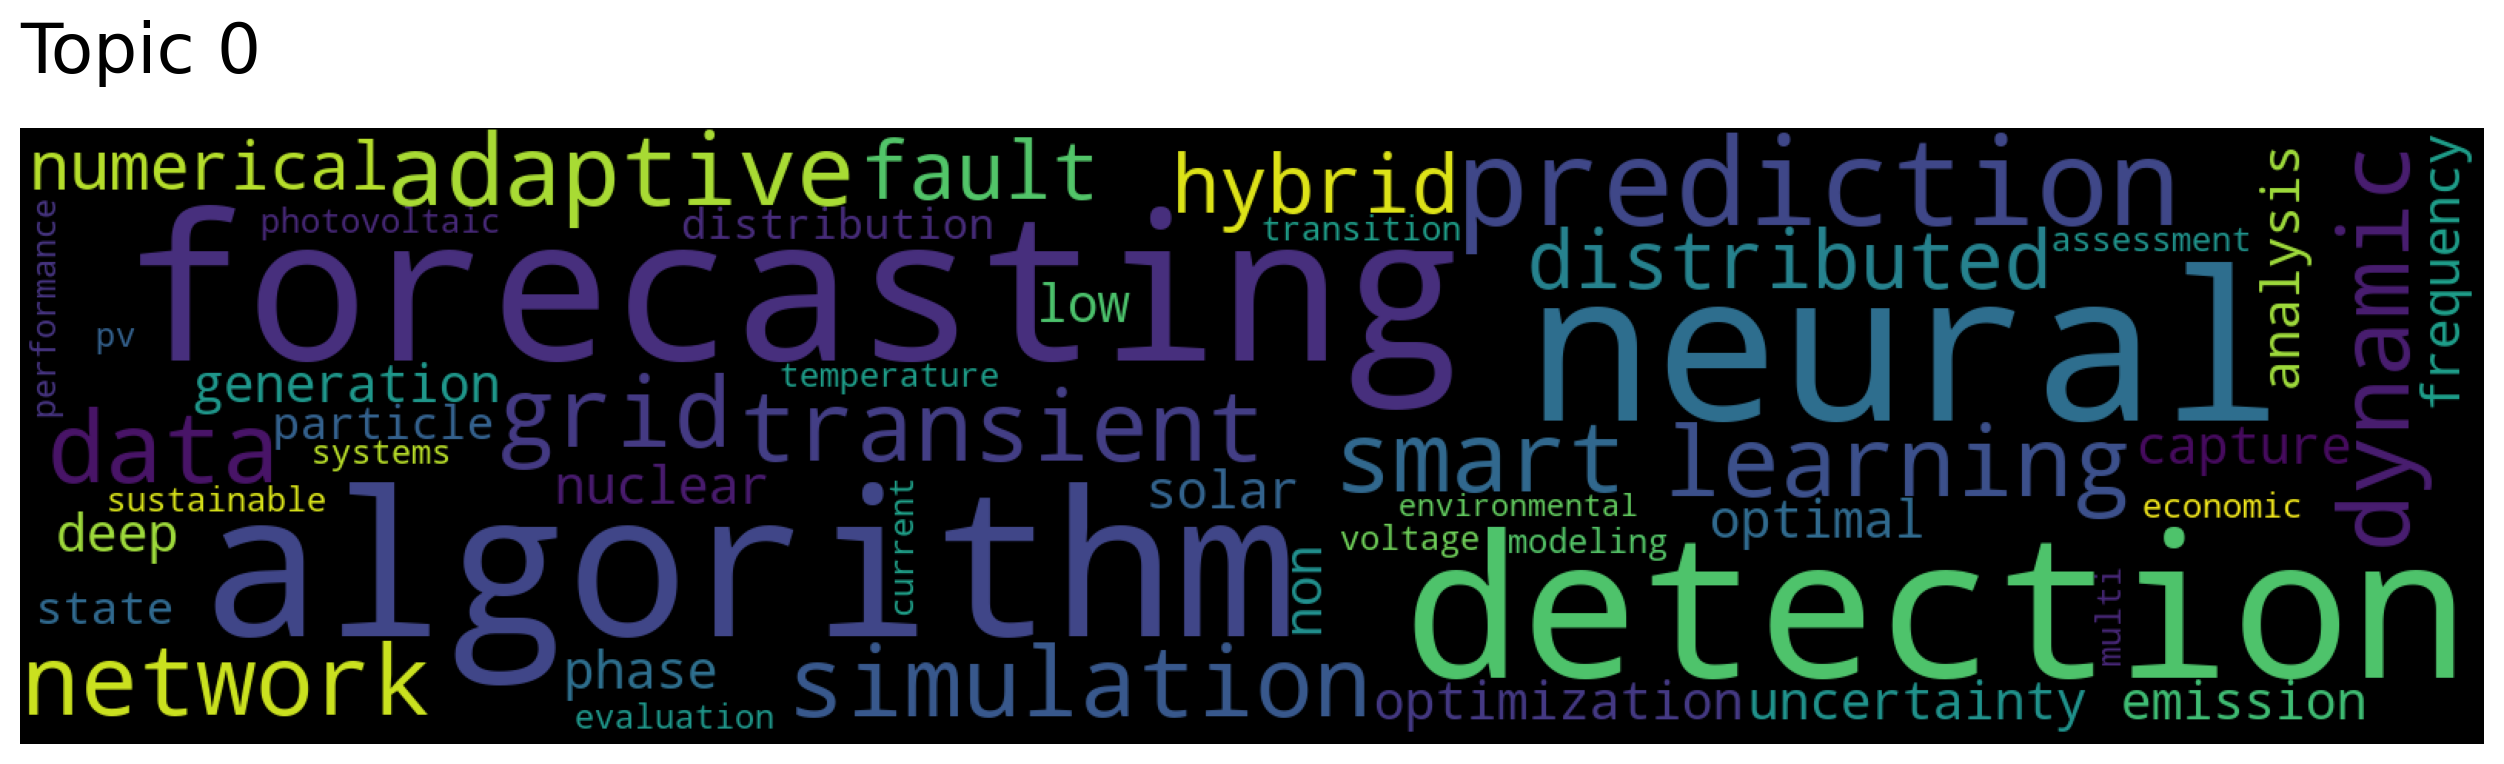

In [34]:
# Generate WordCloud for one of the topic as example

Top2Vec_model.generate_topic_wordcloud(0)

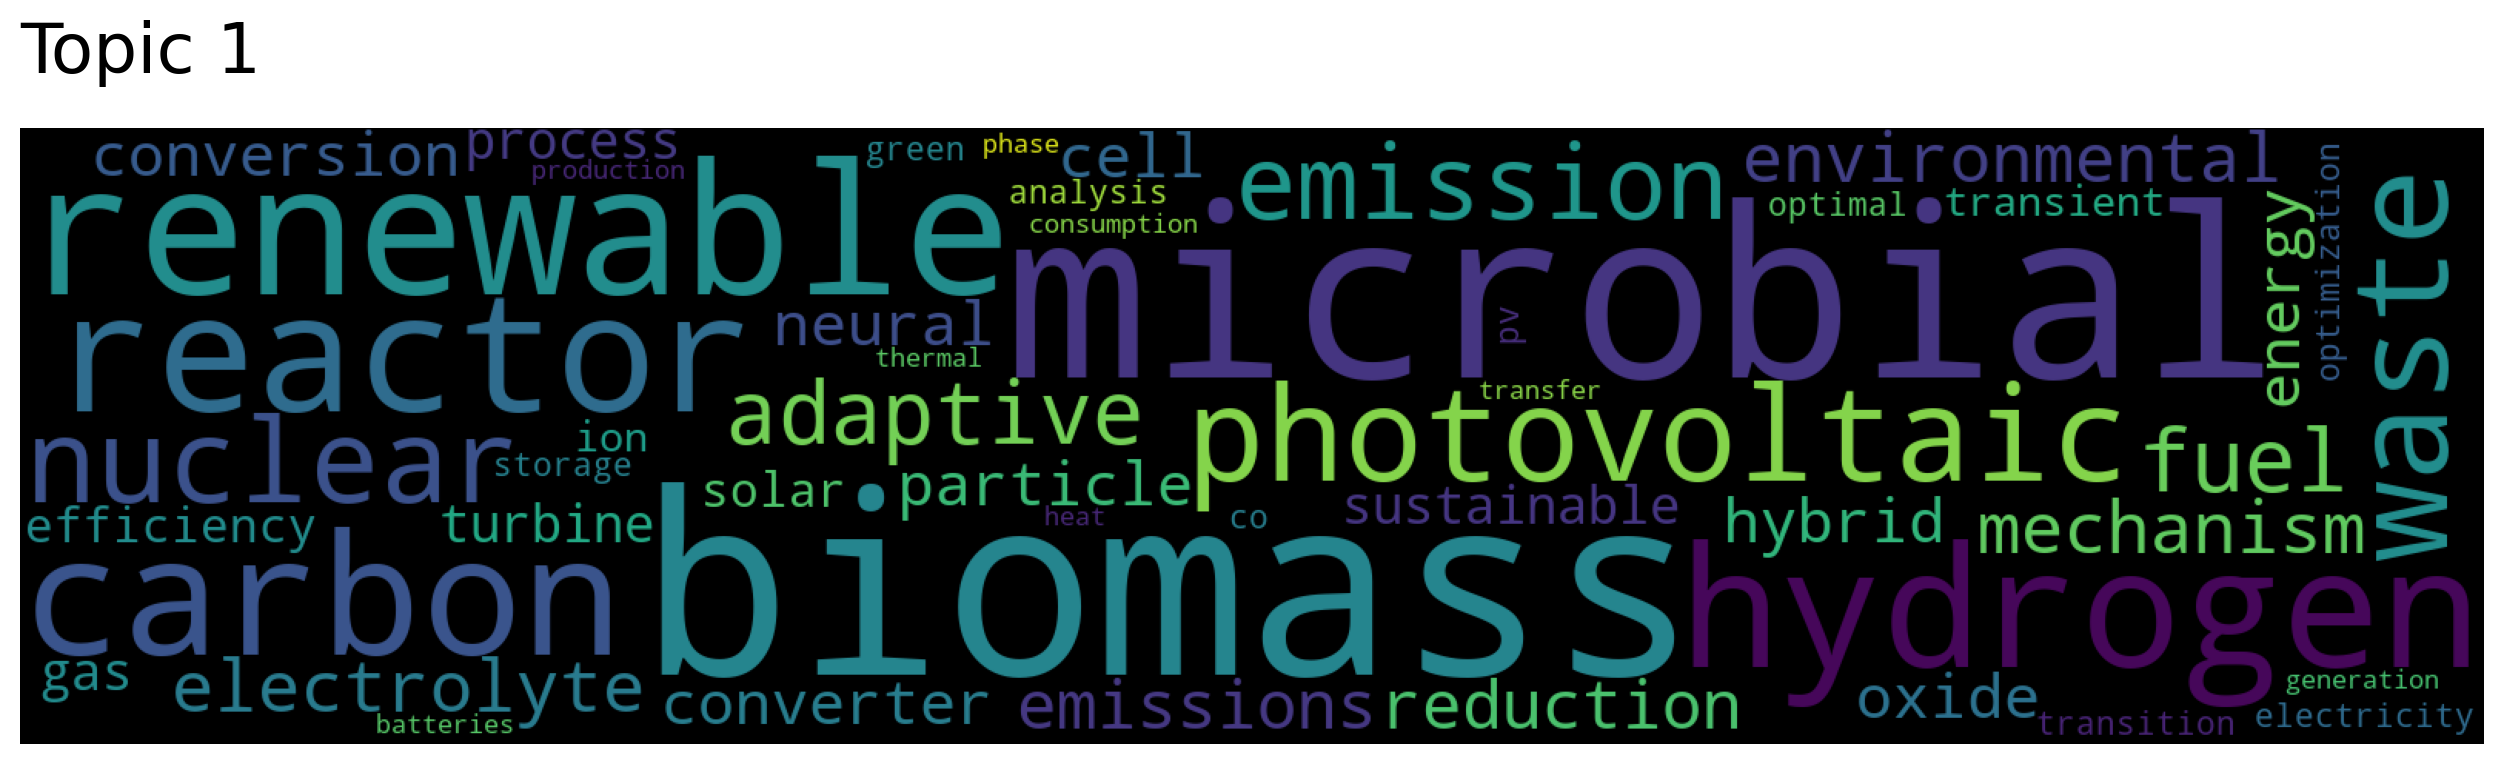

In [35]:
Top2Vec_model.generate_topic_wordcloud(1)

In [36]:
# Access Topic vectors

Top2Vec_model.topic_vectors

array([[ 0.06811653, -0.07682731, -0.0525425 , ...,  0.05140788,
        -0.0818991 , -0.06439292],
       [ 0.1124045 , -0.04796982,  0.00212436, ..., -0.05145954,
        -0.03858601, -0.03972778],
       [ 0.0973206 , -0.05175999, -0.06751224, ...,  0.03053831,
        -0.05252293, -0.03080251],
       ...,
       [ 0.0577038 , -0.04479343, -0.01803088, ..., -0.03608256,
        -0.04357616, -0.07991727],
       [ 0.0471227 , -0.05780749,  0.036825  , ...,  0.04368087,
        -0.06465458, -0.05017753],
       [ 0.03160287, -0.04720901,  0.01695755, ...,  0.00514956,
        -0.07100076, -0.07197818]], dtype=float32)

In [37]:
# Searching for Topics by Keyword

topic_words, word_scores, topic_scores, topic_nums = Top2Vec_model.search_topics(keywords=["turbine"], num_topics=2)

In [38]:
topic_words, topic_scores

([array(['turbine', 'wind', 'nuclear', 'transient', 'renewable', 'energy',
         'electric', 'hybrid', 'reduction', 'frequency', 'environmental',
         'converter', 'power', 'efficiency', 'reactor', 'electricity',
         'solar', 'performance', 'economic', 'phase', 'effect',
         'generation', 'sustainable', 'adaptive', 'pressure', 'emissions',
         'emission', 'low', 'state', 'hydrogen', 'temperature',
         'uncertainty', 'conversion', 'simulation', 'voltage',
         'forecasting', 'optimization', 'non', 'current', 'dynamic',
         'particle', 'demand', 'design', 'gas', 'high', 'response', 'flow',
         'mechanism', 'photovoltaic', 'fuel'], dtype='<U13'),
  array(['simulation', 'turbine', 'pump', 'flow', 'pressure', 'mechanism',
         'frequency', 'cycle', 'model', 'fluid', 'transient', 'phase',
         'response', 'microbial', 'uncertainty', 'pv', 'voltage', 'design',
         'temperature', 'reactor', 'machine', 'wind', 'effect',
         'distributio

In [39]:
# Reducing the number of topics

topic_mapping = Top2Vec_model.hierarchical_topic_reduction(num_topics=6)

In [40]:
print('0 - ',topic_mapping[0])
print('1 - ',topic_mapping[1])
print('2 - ',topic_mapping[2])
print('3 - ',topic_mapping[3])
print('4 - ',topic_mapping[4])
print('5 - ',topic_mapping[5])

0 -  [12, 5, 0]
1 -  [18, 8, 16, 1]
2 -  [6, 9, 10, 13, 17, 11]
3 -  [15, 7, 14, 4]
4 -  [19, 2]
5 -  [3]


In [41]:
Top2Vec_model.topic_words_reduced

array([['algorithm', 'neural', 'forecasting', 'optimization', 'optimal',
        'adaptive', 'dynamic', 'detection', 'simulation', 'distributed',
        'prediction', 'hybrid', 'transient', 'uncertainty', 'grid',
        'data', 'analysis', 'numerical', 'network', 'smart', 'emission',
        'fault', 'learning', 'generation', 'distribution', 'performance',
        'efficiency', 'low', 'phase', 'frequency', 'modeling',
        'reduction', 'multi', 'capture', 'economic', 'particle', 'state',
        'nuclear', 'non', 'pv', 'evaluation', 'sustainable',
        'temperature', 'systems', 'high', 'environmental', 'transition',
        'deep', 'strategy', 'load'],
       ['biomass', 'microbial', 'electrolyte', 'hydrogen', 'carbon',
        'reactor', 'nuclear', 'particle', 'renewable', 'oxide',
        'lithium', 'photovoltaic', 'ion', 'emission', 'reduction',
        'mechanism', 'batteries', 'cell', 'hybrid', 'energy', 'waste',
        'emissions', 'transient', 'transition', 'converter',

As the articles are from the subject renewable energy, the topics get broadly distributed to Energy sources from Wind, Solar and wave energy, Machine learning in RE, Sustainable development and carbon policy, Energy storage, etc. At the end it depend on the users objective to take a call from the above results.   